In [1]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
# from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_style_sheet
import numpy as np
import math as m
import vice
import sys
sys.path.append("..")
from src.utils import mu, get_velocity_profile, boxcarsmoothtrend
load_style_sheet("papers")
print(sys.version_info)

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=2, releaselevel='final', serial=0)


In [21]:
output = vice.output("../outputs/constant/vgas-0p5-new-nomig")

0.0001567746326695573
3.71388212153343
0.0015401673539488273
0.02457155734020783
-0.0005098660318746213


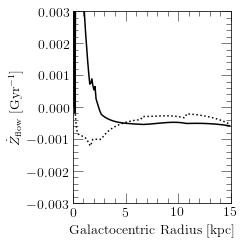

In [22]:
N_RADII = 150

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
# ax.set_xlabel(r"Lookback Time [Gyr]")
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$\dot Z_\text{flow}$ [Gyr$^{-1}$]")
ax.set_xlim([0, 15])
ax.set_ylim([-0.003, 0.003])

def numerical_result(lookback, output, zone_width = 0.1, **kwargs):
    radii, vgas = get_velocity_profile(output, lookback)
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    if idx == len(output.zones["zone0"].history["lookback"]) - 1: idx -= 1
    zdotflow = []
    for i in range(N_RADII):
        zone = output.zones["zone%d" % (i)]
        dt = zone.history["lookback"][idx] - zone.history["lookback"][idx + 1]
        dzdt = (zone.history["z(o)"][idx + 1] - zone.history["z(o)"][idx]) / dt
        if i == 80: print(dzdt)
        zdot = dzdt
        if zone.history["sfr"][i]:
            taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
            eta = zone.history["ofr"][idx] / zone.history["sfr"][idx]
        else:
            zdotflow.append(0)
            continue
        if i == 80: print(taustar)
        if i == 80: print(zone.ccsne_yields['o'] / taustar)
        zdot -= zone.ccsne_yields['o'] / taustar
        dlnmgdt = zone.history["mgas"][idx + 1] - zone.history["mgas"][idx]
        dlnmgdt /= zone.history["mgas"][idx] * dt
        if i == 80: print(dlnmgdt)
        zdot += zone.history["z(o)"][idx] / taustar * (
            1 + eta - zone.history["R_eff"][idx] + taustar * dlnmgdt)
        if i == 80: print(zdot)
        zdotflow.append(zdot)
    return [radii[:N_RADII], zdotflow]

def analytic_expectation(lookback, output, zone_width = 0.1, **kwargs):
    radii, vgas = get_velocity_profile(output, lookback)
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    zdotflow = []
    for i in range(N_RADII):
        zone = output.zones["zone%d" % (i)]
        neighbor = output.zones["zone%d" % (i + 1)]
        dzdr = (neighbor.history["z(o)"][idx] - zone.history["z(o)"][idx]) / zone_width
        zdotflow.append(-vgas[i] * dzdr)
    return [radii[:N_RADII], zdotflow]

def plot_comparison(lookback, output, zone_width = 0.1, **kwargs):
    radii, numeric = numerical_result(0, output, zone_width = zone_width)
    _, analytic = analytic_expectation(0, output, zone_width = zone_width)
    ax.plot(radii, numeric, linestyle = "-", **kwargs)
    ax.plot(radii, analytic, linestyle = ":", **kwargs)

plot_comparison(8, output, c = named_colors()["black"])

plt.tight_layout()
plt.show()